# 1. Data Pre-Processing

### Import Library

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Folder Paths

In [2]:
# source_folder = folder penyimpanan kumpulan dataset yang masih tercampur atau belum dibagi menjadi train, test, dan validation
source_folder = "../dataset/ICDAR-2011"
# train_folder, test_folder, validation_folder = folder tujuan / tempat penyimpanan dataset setelah dibagi di bagian "Train and Test Data Split" 
train_folder = "../template/ICDAR-data/train"
test_folder = "../template/ICDAR-data/test"
validation_folder = "../template/ICDAR-data/validation"

### Train and Test Data Split

In [ ]:
# Hanya membagi data, belum read / membaca gambar 

In [3]:
def extract_label(folder_name):
    return 0 if "_forg" in folder_name else 1

def split_data(source_folder, train_folder, test_folder, validation_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)
    if not os.path.exists(validation_folder):
        os.makedirs(validation_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]
    for signature in signatures:
        signature_path = os.path.join(source_folder, signature)
        images = os.listdir(signature_path)

        label = extract_label(signature)

        train_signature_temp, test_signature = train_test_split(images, test_size=0.2, random_state=3, stratify=[label]*len(images)) #stratify
        train_signature, validation_signature = train_test_split(train_signature_temp, test_size=0.25, random_state=3, stratify=[label]*len(train_signature_temp))

        for sig in train_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(train_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in test_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(test_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

        for sig in validation_signature:
            source_path = os.path.join(signature_path, sig)
            destination_path = os.path.join(validation_folder, signature)
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)
            destination_path = os.path.join(destination_path, sig)
            shutil.copy(source_path, destination_path)

In [4]:
# split_data(source_folder, train_folder, test_folder, validation_folder)

# 2. Feature Extraction

### Load vgg16 model

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

In [6]:
model = VGG16(weights='imagenet', include_top=False)

### Extract Features

In [7]:
from tensorflow.keras.models import Model
import cv2 as cv

In [8]:
size = 224

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [12]:
# train_features, train_names, train_labels = extract_features(train_folder)
# test_features, test_names, test_labels = extract_features(test_folder)
# validation_features, validation_names, validation_labels = extract_features(validation_folder)

### Save and Load Features, Names, and Labels to reduce time needed

In [13]:
train_features_path =  "../template/ICDAR-feature/train_features.npy"
train_names_path = "../template/ICDAR-feature/train_names.npy"
train_labels_path = "../template/ICDAR-feature/train_labels.npy"

test_features_path = "../template/ICDAR-feature/test_features.npy"
test_names_path = "../template/ICDAR-feature/test_names.npy"
test_labels_path = "../template/ICDAR-feature/test_labels.npy"

validation_features_path = "../template/ICDAR-feature/validation_features.npy"
validation_names_path = "../template/ICDAR-feature/validation_names.npy"
validation_labels_path = "../template/ICDAR-feature/validation_labels.npy"

In [14]:
# np.save(train_features_path, train_features)
# np.save(train_names_path, train_names)
# np.save(train_labels_path, train_labels)

# np.save(test_features_path, test_features)
# np.save(test_names_path, test_names)
# np.save(test_labels_path, test_labels)

# np.save(validation_features_path, validation_features)
# np.save(validation_names_path, validation_names)
# np.save(validation_labels_path, validation_labels)

In [15]:
train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

### Feature Gallery

In [16]:
# Feature Gallery dilakukan untuk setiap kelas / nama seperti "001", "002", "003", dst dengan cara mengambil data training positive dan mengambil mean / rata-rata dari data tersebut
def create_feature_gallery(train_features, train_names, train_labels):
    gallery_feature = []
    gallery_name = []

    unique_names = set(train_names.flatten())
    sorted_names = sorted(unique_names)

    for name in sorted_names:
        # print(name)
        # print(name)
        name_features = []

        for feature, feature_name, label in zip(train_features, train_names, train_labels):
            # print(feature, feature_name, label)
            if name in feature_name and label == 1:
                name_features.append(feature)

        if name_features:
            # print(name_features)
            average_feature = np.mean(name_features, axis=0)
            gallery_feature.append(average_feature)
            gallery_name.append(name)

    return gallery_feature, gallery_name

In [17]:
gallery_features, gallery_names = create_feature_gallery(train_features, train_names, train_labels)

### Euclidean Distance

In [18]:
def euclidean_distance(feature_vector1, feature_vector2):
    return np.sqrt(np.sum((feature_vector1 - feature_vector2)**2))

In [19]:
def find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names):
    euclidean_distances = []
    euclidean_names = []
    euclidean_actual_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_euclid_name = gallery_name
        curr_euclid_feature = []
        curr_euclid_label = []
        curr_euclid_dist = []
        for feature, name, label in zip(test_features, test_names, test_labels):
            if gallery_name in name:
                curr_euclid_feature.append(feature)
                curr_euclid_label.append(label)
        
        for feature in curr_euclid_feature:
            distance = euclidean_distance(feature, gallery_feature)
            curr_euclid_dist.append(distance)

        euclidean_distances.append(curr_euclid_dist)
        euclidean_names.append(curr_euclid_name)
        euclidean_actual_labels.append(curr_euclid_label)
        
    return euclidean_distances, euclidean_names, euclidean_actual_labels

In [20]:
euclidean_distances, euclidean_names, euclidean_actual_labels = find_euclidean_distance(test_features, test_names, test_labels, gallery_features, gallery_names)

In [21]:
# print(euclidean_actual_labels)

### Split Euclidean Distance to Positive and Negative for Future Use (If needed)

In [22]:
positive_distance = []
positive_name = []
positive_label = []
negative_distance = []
negative_name = []
negative_label = []

for euclidean_distance, euclidean_name, euclidean_actual_label in zip(euclidean_distances, euclidean_names, euclidean_actual_labels):
    pos_dist = []
    neg_dist = []
    pos_lab = []
    neg_lab = []
    for distance, label in zip(euclidean_distance, euclidean_actual_label):
        if label == 0:
            neg_dist.append(distance)
            neg_lab.append(label)
        else:
            pos_dist.append(distance)
            pos_lab.append(label)

    positive_distance.append(pos_dist)
    positive_name.append(euclidean_name)
    positive_label.append(pos_lab)

    negative_distance.append(neg_dist)
    negative_name.append(euclidean_name)
    negative_label.append(neg_lab)
    # print(euclidean_distance, euclidean_name, euclidean_actual_label)

### Normalize Euclidean Distance

In [23]:
def normalize_distance(euclidean_distances):
    all_distances = []
    for distances in euclidean_distances:
        min_distance = min(distances)
        max_distance = max(distances)

        normalized_distances = [(d - min_distance) / (max_distance - min_distance) for d in distances]
        all_distances.append(normalized_distances)

    return all_distances

def reverse_normalized_distance(euclidean_distances):
    reverse_distance = []
    normalized_distances = normalize_distance(euclidean_distances)
    for distances in normalized_distances:
        temp = []
        for distance in distances :
            distance = -distance
            temp.append(distance)
        reverse_distance.append(temp)
    return reverse_distance

In [24]:
normalized_positive_distances = reverse_normalized_distance(positive_distance)
normalized_negative_distances = reverse_normalized_distance(negative_distance)

In [25]:
normalized_euclidean_distance = reverse_normalized_distance(euclidean_distances)

# 3. ROC Curve

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

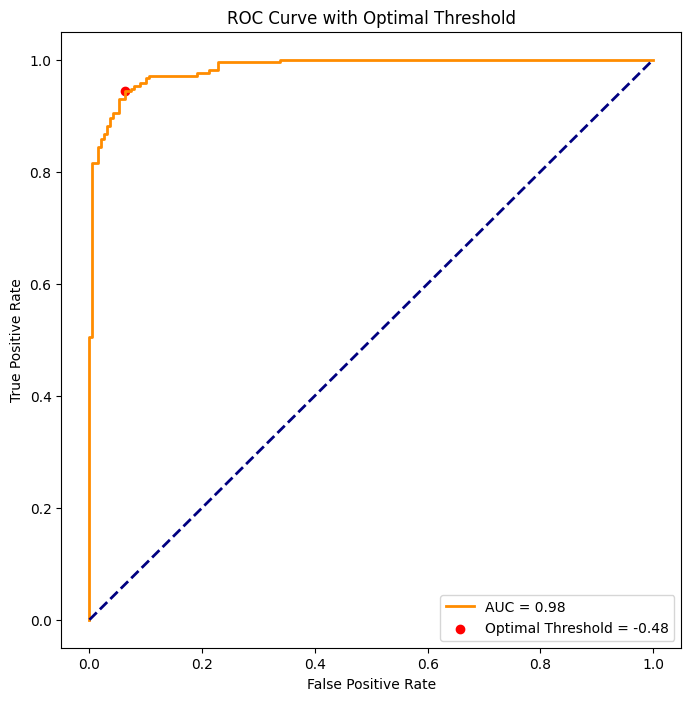

In [35]:
# Flatten the lists of distances
flat_euclidean_distances = [item for sublist in normalized_euclidean_distance for item in sublist]

# Flatten the lists of labels
flat_euclidean_labels = [item for sublist in euclidean_actual_labels for item in sublist]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(flat_euclidean_labels, flat_euclidean_distances)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic
J_values = tpr - fpr
optimal_idx = np.argmax(J_values)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.show()